In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [ ]:
# Load the data
df = pd.read_csv('cluxton.csv')

# Sort the data by MatchID and MinutesGone
df.sort_values(by=['MatchID', 'MinutesGone'], inplace=True)

# Calculate the rolling change in Score_diff
df['Score_diff_change'] = df.groupby('MatchID')['Score_diff'].diff().fillna(0)

# Bin MinutesGone into match quarters
bins = [0, 17, 35, 55, np.inf]
labels = ['Q1', 'Q2', 'Q3', 'Q4']
df['MatchQuarter'] = pd.cut(df['MinutesGone'], bins=bins, labels=labels, right=False)

# Drop columns
df = df.drop(['MinutesGone', 'KickoutLength', 'TargetOpen', 'KickoutWon?'], axis=1)

# Separate features and target variable
X = df.drop(['TargetArea', 'KickoutID', 'MatchID'], axis=1)
y = df['TargetArea']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['number']).columns.tolist()

# Create preprocessors for numerical and categorical data
numerical_preprocessor = StandardScaler()
categorical_preprocessor = OneHotEncoder(handle_unknown='ignore')

# Create a column transformer to apply the appropriate preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_preprocessor, numerical_cols),
        ('cat', categorical_preprocessor, categorical_cols)
    ])

# Fit the preprocessor and transform the training data
X_train_processed = preprocessor.fit_transform(X_train)

# Transform the test data
X_test_processed = preprocessor.transform(X_test)

# Encode the target variable
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))


In [ ]:

# Define the model with L2 regularization and Dropout
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(X_train_processed.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(y_train_encoded.shape[1], activation='softmax')
])



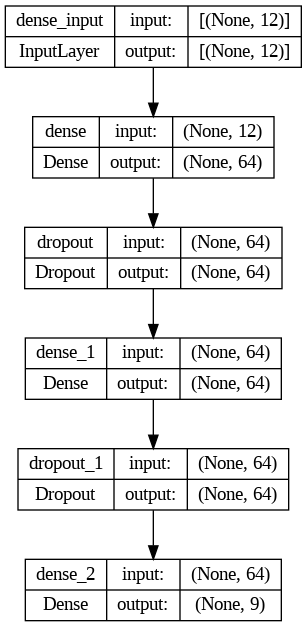

In [ ]:
from tensorflow.keras.utils import plot_model

# Plot the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(X_train_processed, y_train_encoded, epochs=100, batch_size=32, verbose =1, validation_split=0.2)



Epoch 1/100
4/4 [==============================] - 0s 55ms/step - loss: 1.8963 - accuracy: 0.4035 - val_loss: 2.3609 - val_accuracy: 0.2759
Epoch 2/100
4/4 [==============================] - 0s 25ms/step - loss: 1.8037 - accuracy: 0.4561 - val_loss: 2.3642 - val_accuracy: 0.2759
Epoch 3/100
4/4 [==============================] - 0s 28ms/step - loss: 1.8052 - accuracy: 0.4737 - val_loss: 2.3699 - val_accuracy: 0.2759
Epoch 4/100
4/4 [==============================] - 0s 22ms/step - loss: 1.8164 - accuracy: 0.4386 - val_loss: 2.3735 - val_accuracy: 0.2759
Epoch 5/100
4/4 [==============================] - 0s 27ms/step - loss: 1.7925 - accuracy: 0.4386 - val_loss: 2.3720 - val_accuracy: 0.2759
Epoch 6/100
4/4 [==============================] - 0s 31ms/step - loss: 1.8119 - accuracy: 0.4123 - val_loss: 2.3620 - val_accuracy: 0.2759
Epoch 7/100
4/4 [==============================] - 0s 28ms/step - loss: 1.8302 - accuracy: 0.4561 - val_loss: 2.3613 - val_accuracy: 0.2759
Epoch 8/100
4/4 [===

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_processed, y_test_encoded)
print(f'Test set accuracy: {accuracy:.2%}')


2/2 [==============================] - 0s 6ms/step - loss: 2.4286 - accuracy: 0.2778
Test set accuracy: 27.78%


In [ ]:
new_input = {
    'Score_diff': 2,
    'Score_diff_change': 3,
    'LastPlay': 'Wide',
    'Press': 'Mid',
    'MatchQuarter': 'Q2'
}


# Convert the input data to a DataFrame
new_input_df = pd.DataFrame([new_input])

# Process the new input using the same preprocessor used on the training data
new_input_processed = preprocessor.transform(new_input_df)

# Make predictions as before
predictions = model.predict(new_input_processed)

# Convert the probabilities to percentages and format the output
predictions_percentages = pd.DataFrame(predictions, columns=encoder.get_feature_names_out()).iloc[0] * 100
predictions_formatted = predictions_percentages.round(2).astype(str) + '%'


# Removing the 'x0_' prefix from the index
predictions_formatted.index = predictions_formatted.index.str.replace('x0_', '')

# Convert the pandas Series to a string without the 'Name: 0' part
formatted_output = predictions_formatted.to_string(header=False)

print(formatted_output)


# Convert percentage strings back to floats and sum them
total_percentage = predictions_percentages.sum()

print(f"Total percentage: {total_percentage:.2f}%")




1/1 [==============================] - 0s 86ms/step
LongLeft        0.8%
LongMid        0.88%
LongRight      2.68%
MidLeft         0.6%
MidMid         0.72%
MidRight      14.59%
ShortLeft     11.51%
ShortMid      42.37%
ShortRight    25.84%
Total percentage: 100.00%


In [ ]:
import joblib

# Save the encoder
joblib.dump(encoder, 'encoder.pkl')

# Save the preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')

# Save the model
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
